# Fútbol bayesiano

Carga de librerías

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cmdstanpy import CmdStanModel
from ipywidgets import widgets

Se definen rutas relativas del archivo

In [2]:
CURRENT = os.getcwd()
ROOT = os.path.dirname(CURRENT)

Cargar en memoria archivo de configuración

In [3]:
with open(os.path.join(ROOT, 'config.yml'), 'r') as file_:
    config = yaml.safe_load(file_)
file_.close()

Carga en memoria de los datos

In [4]:
df_ = (
    # --------------------------------------------------- Carga de datos crudos
    pd.read_csv(
        os.path.join(ROOT, config['datos']['raw'])
        ,encoding='latin1')
    # ---------------------------------------------------- Acotar datos a scope
    .query("year > 2018")
    .query("tournament == 'FIFA World Cup qualification'")
    # --------------------------------------------- Filtrar columnas de interés
    .filter(items=[
        'date'
        ,'tournament'
        ,'home_team'
        ,'away_team'
        ,'home_team_continent'
        ,'away_team_continent'
        ,'home_team_score'
        ,'away_team_score'
    ])
    # ------------------------------------ Transformación a columnas existentes
    .assign(
        date = lambda df_: pd.to_datetime(df_.date)
        ,home_team = lambda df_: pd.Categorical(df_.home_team)
        ,away_team = lambda df_: pd.Categorical(df_.away_team)
        ,home_team_continent = lambda df_: pd.Categorical(df_.home_team_continent)
        ,away_team_continent = lambda df_: pd.Categorical(df_.away_team_continent)
    )
    # --------------------------------------- Asignación de columnas computadas
    .assign(
        result = lambda df_: 
            # -1: Away win, 0: Draw, 1: Home win
            (df_.home_team_score - df_.away_team_score).apply(np.sign)
    )
)

df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 863 entries, 21128 to 23890
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 863 non-null    datetime64[ns]
 1   tournament           863 non-null    object        
 2   home_team            863 non-null    category      
 3   away_team            863 non-null    category      
 4   home_team_continent  863 non-null    category      
 5   away_team_continent  863 non-null    category      
 6   home_team_score      863 non-null    int64         
 7   away_team_score      863 non-null    int64         
 8   result               863 non-null    int64         
dtypes: category(4), datetime64[ns](1), int64(3), object(1)
memory usage: 65.3+ KB


# 2. Modelo en STAN

$$y^h\sim Poisson(\theta^h)$$
$$y^a\sim Poisson(\theta^a)$$
$$log(\theta^h) = home_{boost} + attack_{i[h]} - defence_{i[a]} + intercept$$
$$log(\theta^a) = attack_{i[a]} - defence_{i[h]} + intercept$$

## 2.1. Muestreo

Primero se definen algunas funciones útiles para la creación y manipulación de archivos de `stan`, y se crea un proyecto nuevo para la primera iteración del modelo jerárquico.

In [5]:
import BFG3000 as bfg

In [6]:
name = 'dinam_iter1'
sp_ = bfg.StanProject(name)
dir_, model_ = sp_.create_stan_project(dir='modelos')

Ya existe un proyecto con el nombre dinam_iter1


Una vez creado y editado el proyecto de STAN, se declara el siguiente bloque de código para mantener estructura en la compilación del modelo y los archivos que éste genera.

In [9]:
# Compilar el modelo
compile_ = CmdStanModel(
    model_name=name
    ,stan_file=model_
    ,compile=True)

Se delcara un diccionario de datos para proporcionar los datos a stan

In [10]:
stan_data_ = {
    'n_matches': df_.shape[0]
    ,'goals_home': df_.home_team_score.values
    ,'goals_away': df_.away_team_score.values
}

Finalmente, se ejecuta el modelo y se calibra. Este paso es recursivo y se tiene que ejecutar tantas veces sean necesarias de modo que las cadenas generadas por el muestreador tengan diagnósticos buenos.

In [11]:
fit_ = compile_.sample(
    data=stan_data_
    ,chains=3
    ,iter_warmup=3_000
    ,iter_sampling=3_000
    ,show_progress=True
    ,save_warmup=False
)

13:41:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

13:43:24 - cmdstanpy - INFO - CmdStan done processing.
13:43:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.stan', line 33, column 4 to column 30)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.stan', line 34, column 4 to column 32)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.stan', line 34, column 4 to column 32)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.stan', line 33, column 4 to column 30)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/mod

13:43:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 18 iterations at max treedepth (0.6%)
	Chain 2 had 251 iterations at max treedepth (8.4%)
	Use function "diagnose()" to see further information.


In [12]:
diagnose_path = os.path.join(dir_, name + '_diagnose.txt')

with open(diagnose_path, 'w') as file_:
    file_.write(fit_.diagnose())
file_.close()

## 2.2 Resumen de estimadores

In [13]:
summary_ = fit_.summary()
summary_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5181 entries, lp__ to lambda_away[863]
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Mean     5181 non-null   float64
 1   MCSE     5181 non-null   float64
 2   StdDev   5181 non-null   float64
 3   5%       5181 non-null   float64
 4   50%      5181 non-null   float64
 5   95%      5181 non-null   float64
 6   N_Eff    5181 non-null   float64
 7   N_Eff/s  5181 non-null   float64
 8   R_hat    5181 non-null   float64
dtypes: float64(9)
memory usage: 404.8+ KB


Número de parámetros

In [14]:
summary_vis_ = (
    summary_
    .reset_index(names='param')
    .assign(
        param = lambda df_: df_.param.str.partition('[')[0]
    )
)

summary_vis_.param.value_counts()

param
intercept         863
home_boost        863
attack            863
deffence          863
lambda_home       863
lambda_away       863
lp__                1
sigma_attack        1
sigma_deffence      1
Name: count, dtype: int64

### 2.2.1 MCSE

Primero se observa el `MCSE` de lo parámetros únicos

In [22]:
# Datos de visualización
diagnostico = 'MCSE'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

single_params = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
).param.values.to_list()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,MCSE
0,lp__,117.840000
3453,sigma_attack,0.117901
3454,sigma_deffence,0.082433


Visualización del error estándar MC de los parámetros múltiples

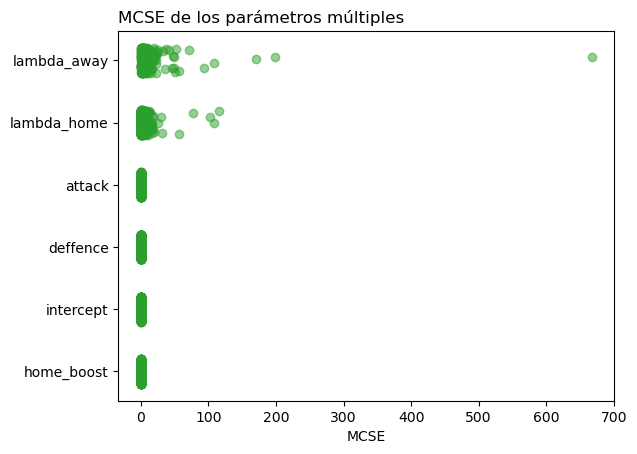

In [23]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='tab:green'
    ,alpha=0.5)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.2 Número efectivo de simulaciones

Primero se observa el `N_Eff` de lo parámetros únicos

In [24]:
# Datos de visualización
diagnostico = 'N_Eff'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,N_Eff
0,lp__,22.381500
3453,sigma_attack,18.878787
3454,sigma_deffence,28.650998


Visualización del error estándar MC de los parámetros múltiples

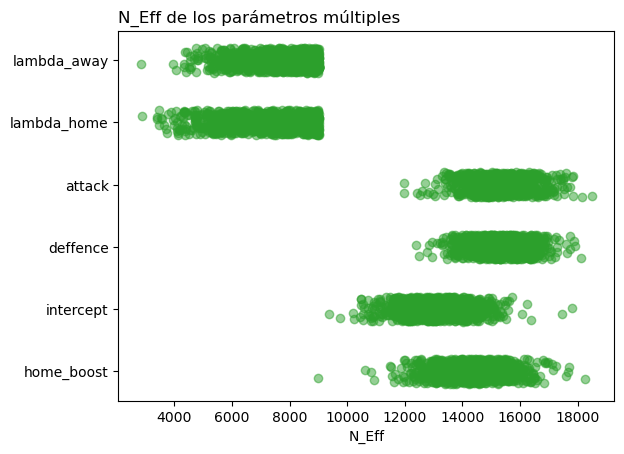

In [25]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='tab:green'
    ,alpha=0.5)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.3 Factor de reducción de escala

Primero se observa el `R_hat` de lo parámetros únicos

In [26]:
# Datos de visualización
diagnostico = 'R_hat'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,R_hat
0,lp__,1.172390
3453,sigma_attack,1.278206
3454,sigma_deffence,1.086452


Visualización del error estándar MC de los parámetros múltiples

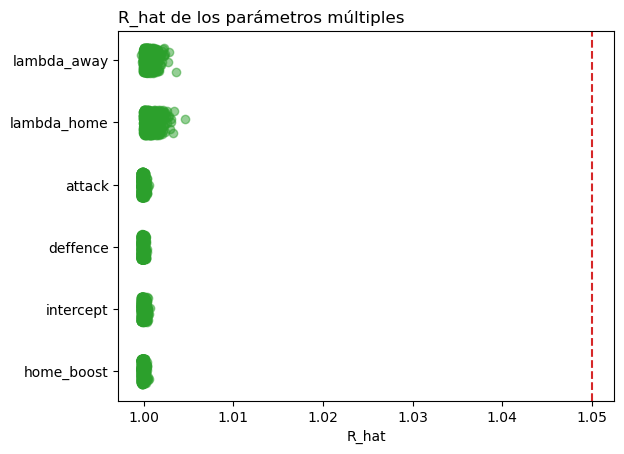

In [27]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='tab:green'
    ,alpha=0.5)
ax.axvline(x=1.05, color='tab:red', linestyle='--')

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.4 Traza de las cadenas

In [28]:
chains_ = fit_.draws(inc_warmup=False, concat_chains=False)
chains_.shape

(3000, 3, 5187)

Parámetros simples

In [29]:
def traceplot_single_param(param, type):
    idp_ = fit_.column_names.index(param)
    arr_ = chains_[:, :, idp_]

    # Especificaciones de figura
    plt.figure(figsize=(10,5))

    if type == 'traceplot':
        # Visualizaciones
        for chain in range(arr_.shape[1]):
            plt.plot(arr_[:, chain], label=f'Chain: {chain}')

        # Anotaciones y estilo
        plt.title(f'Traza de las cadenas, {param}', loc='left')
        plt.xlabel('Iteraciones')
        plt.ylabel('Espacio parametral')
        plt.legend()

    if type == 'convergence':
        ergo_ = np.apply_along_axis(func1d=lambda x: x.cumsum(), axis=0, arr=arr_)
        ergo_ = ergo_ / np.arange(1, ergo_.shape[0]+1, 1).reshape((-1,1))

        # Visualizaciones
        for chain in range(ergo_.shape[1]):
            plt.plot(ergo_[:, chain], label=f'Chain: {chain}')

        # Anotaciones y estilo
        plt.title(f'Promedios ergódicos, {param}', loc='left')
        plt.xlabel('Iteraciones')
        plt.ylabel('Espacio parametral')
        plt.legend()

    plt.show()

In [30]:
widgets.interact(
    traceplot_single_param
    ,param=widgets.Dropdown(
        options=single_params
        ,description='Param'
        ,disabled=False)
    ,type=widgets.Dropdown(
        options=['traceplot','convergence']
        ,description='Type'
        ,disabled=False)
        
)

interactive(children=(Dropdown(description='Param', options=('lp__', 'sigma_attack', 'sigma_deffence'), value=…

<function __main__.traceplot_single_param(param, type)>